In [1]:
import numpy
import matplotlib
from matplotlib import pyplot
import pandas
import scipy
import seaborn

import tensorflow
import tensorflow.keras
from sklearn import preprocessing

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
pandas.set_option('display.max_columns', None)

In [3]:
# Helper functions
def one_hot_encode(sequences, max_seq_len=None, mask_val=-1, padding='left'):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],
             'c':[0,1,0,0],
             'g':[0,0,1,0],
             't':[0,0,0,1],
             'n':[0,0,0,0]}

    # Automatically use max length if not specified
    if max_seq_len is None:
        max_seq_len = numpy.max([len(s) for s in sequences])
    
    # Creat empty matrix
    one_hot_seqs = numpy.ones([len(sequences), max_seq_len, 4])*mask_val
    
    # Iterate through sequences and one-hot encode
    for i, seq in enumerate(sequences):
        # Truncate
        if padding=='left':
            seq = seq[:max_seq_len]
        elif padding=='right':
            seq = seq[-max_seq_len:]
        else:
            raise ValueError(f'padding {padding} not recognized')
        # Convert to array
        seq = seq.lower()
        one_hot_seq = numpy.array([nuc_d[x] for x in seq])
        # Append to matrix
        if padding=='left':
            one_hot_seqs[i, :len(seq), :] = one_hot_seq
        elif padding=='right':
            one_hot_seqs[i, -len(seq):, :] = one_hot_seq
        else:
            raise ValueError(f'padding {padding} not recognized')
            
    return one_hot_seqs

# N25 library, replicate vs. replicate

In [4]:
# Load independent replicate data
data_full_r1 = pandas.read_csv(
    '../polysome_profiling_data/GSE232927_processed_random_end_hek293t_N25_r1.csv.gz',
    usecols=['UTR', 'total', 'rl'],
)
# display(data_full_r1)
data_full_r2 = pandas.read_csv(
    '../polysome_profiling_data/GSE232927_processed_random_end_hek293t_N25_r2.csv.gz',
    usecols=['UTR', 'total', 'rl'],
)
# display(data_full_r2)

# Combine replicates
data_full = pandas.merge(data_full_r1, data_full_r2, how='outer', on='UTR', suffixes=['_r1', '_r2'])
data_full['total_r1'] = data_full['total_r1'].fillna(0)
data_full['total_r2'] = data_full['total_r2'].fillna(0)
data_full['rl_r1'] = data_full['rl_r1'].fillna(0)
data_full['rl_r2'] = data_full['rl_r2'].fillna(0)

data_full['total'] = data_full['total_r1'] + data_full['total_r2']
data_full['rl'] = (data_full['rl_r1']*data_full['total_r1'] + data_full['rl_r2']*data_full['total_r2'])/data_full['total']

# Preserve only sequences with largest number of reads
data_full.sort_values('total', inplace=True, ascending=False)
data_full.reset_index(inplace=True, drop=True)
data = data_full[data_full['total'] >= 100]

print("{:,} total sequences, {:,} retained.".format(len(data_full), len(data)))
data

669,847 total sequences, 168,279 retained.


,UTR,total_r1,rl_r1,total_r2,rl_r2,total,rl
0,ACATCGTAGAGAGTCGTACTTACCG,13193.0,5.686971,7059.0,5.317719,20252.0,5.558265
1,AGAAGGTCGCGGCGTTTAGAATTCA,9648.0,6.589508,9307.0,6.686497,18955.0,6.637130
2,AGAGATGAGCATTAAAATGGAACAA,7047.0,6.055439,5220.0,6.250219,12267.0,6.138324
3,AGAGGATTTGAGGTTTTCGCATATT,6932.0,6.650055,5055.0,6.874601,11987.0,6.744748
4,TCTACCGACGGTTAGTATTTATGCC,5719.0,6.539420,4536.0,6.468370,10255.0,6.507993
...,...,...,...,...,...,...,...
168274,AGACTCAGAAACAAGTTAAGAGGGA,57.0,7.823094,43.0,4.604686,100.0,6.439179
168275,TGCAATGAAATTTTGGCTGAAAGGA,69.0,5.968804,31.0,6.289242,100.0,6.068140
168276,GGGGGCCGTCATGATCAAACTTAAT,39.0,4.002621,61.0,8.070580,100.0,6.484076
168277,CGTAGTCGTCTATGTAATGAGCAAG,67.0,8.311776,33.0,7.180228,100.0,7.938365


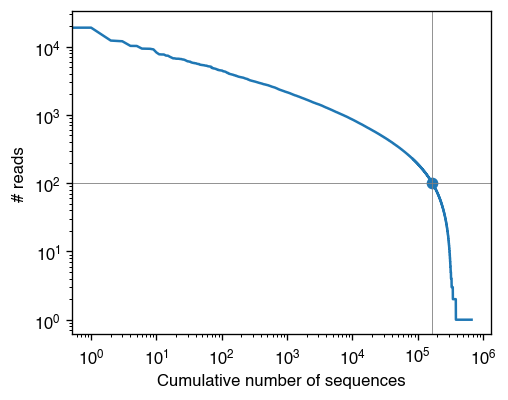

In [5]:
fig, ax = pyplot.subplots(1, 1, figsize=(4.5, 3.5))
ax.plot(data_full['total'])
ax.axhline(100, color='gray', linewidth=0.5)
ax.axvline(len(data), color='gray', linewidth=0.5)
ax.scatter(len(data), 100)
ax.set_xscale('log')
ax.set_xlabel('Cumulative number of sequences')
ax.set_yscale('log')
ax.set_ylabel(f'# reads')
fig.savefig('N25_reads_nseqs.png', dpi=200, bbox_inches='tight')
fig.savefig('N25_reads_nseqs.svg', dpi=200, bbox_inches='tight')

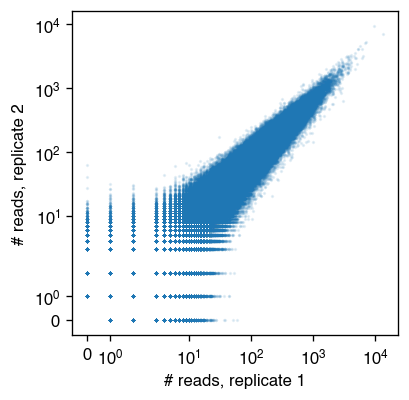

In [6]:
# Scatter plot of # reads
fig, ax = pyplot.subplots(1, 1, figsize=(3.5, 3.5))
ax.scatter(
    data_full['total_r1'],
    data_full['total_r2'],
    alpha=0.1,
    s=1,
    rasterized=True,
)

# Scale
ax.set_xscale('symlog', linthresh=3)
ax.set_yscale('symlog', linthresh=3)

# Set axis labels based on position
ax.set_xlabel("# reads, replicate 1")
ax.set_ylabel("# reads, replicate 2")
fig.savefig('N25_reads_replicates.png', dpi=200, bbox_inches='tight')
fig.savefig('N25_reads_replicates.svg', dpi=200, bbox_inches='tight')

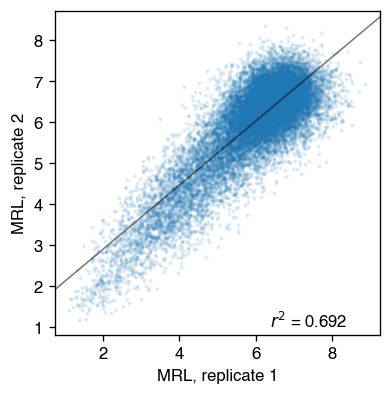

In [8]:
# Scatter plot of MRL
# Filter by number of reads
# r^2 = 0.692 when filtering for only the first 20000
# r^2 = 0.844 when filtering for only the first 2000
data_to_plot = data[:20000]
fig, ax = pyplot.subplots(1, 1, figsize=(3.5, 3.5))
ax.scatter(
    data_to_plot['rl_r1'],
    data_to_plot['rl_r2'],
    alpha=0.1,
    s=2,
    rasterized=True,
)

# Regression line
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(data_to_plot['rl_r1'], data_to_plot['rl_r2'])
ax.axline((3, 3*slope + intercept), slope=slope, color='k', linewidth=1, alpha=0.5)

ax.text(8.4, 1, f'$r^2$ = {r_value**2:.3f}', ha='right')

# Set axis labels based on position
ax.set_xlabel("MRL, replicate 1")
ax.set_ylabel("MRL, replicate 2")
fig.savefig('N25_mrl_replicates.png', dpi=200, bbox_inches='tight')
fig.savefig('N25_mrl_replicates.svg', dpi=200, bbox_inches='tight')

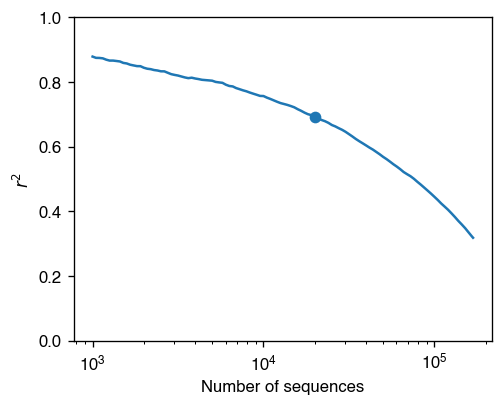

In [8]:
# Scatter plot of MRL
data_to_plot = data

read_th_list = 10**numpy.arange(3, numpy.log10(len(data_to_plot)), 0.02)
read_th_list = [int(read_th) for read_th in read_th_list]
if read_th_list[-1] < len(data_to_plot):
    read_th_list.append(len(data_to_plot))

r2_list = []
for read_th in read_th_list:

    # Apply threshold
    data_th = data_to_plot.iloc[:read_th]

    # Calculate regression and r^2
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        data_th['rl_r1'].values,
        data_th['rl_r2'].values,
    )

    r2_list.append(r_value**2)

# Calculate r^2 for the selected threshold number, to be shown with a dot
read_th_dot = 20000
data_th_dot = data_to_plot.iloc[:read_th_dot]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    data_th_dot['rl_r1'].values,
    data_th_dot['rl_r2'].values,
)
r2_th_dot = r_value**2


fig, ax = pyplot.subplots(1, 1, figsize=(4.5, 3.5))

# Plot r^2
plot_lines = ax.plot(
    read_th_list,
    r2_list,
    # color='k',
    # marker='o',
)

# Plot selected r^2
ax.plot([read_th_dot], [r2_th_dot], linestyle='', marker='o', color=plot_lines[0].get_color())

ax.set_xscale('log')
# ax.set_xlim(7e2, 4e5)
ax.set_ylim(0, 1.)

# # Set axis labels based on position
ax.set_xlabel("Number of sequences")
ax.set_ylabel("$r^2$")
fig.savefig('N25_r2_vs_nseqs.png', dpi=200, bbox_inches='tight')
fig.savefig('N25_r2_vs_nseqs.svg', dpi=200, bbox_inches='tight')

In [ ]:
# Save combined data
data.to_csv('../polysome_profiling_data/GSE232927_processed_random_end_hek293t_N25_combined.csv.gz', index=False)

# N25 library

In [9]:
data_full = pandas.read_csv('../polysome_profiling_data/GSE232927_processed_random_end_hek293t_N25_combined.csv.gz')

# Preserve only sequences with largest number of reads
data_full.sort_values('total', inplace=True, ascending=False)
data_full.reset_index(inplace=True, drop=True)
data = data_full[data_full['total'] >= 100]

print("{:,} total sequences, {:,} retained.".format(len(data_full), len(data)))
data


669,847 total sequences, 168,279 retained.


,UTR,total,rl,error
0,ACATCGTAGAGAGTCGTACTTACCG,20252.0,5.584273,0.140398
1,AGAAGGTCGCGGCGTTTAGAATTCA,18955.0,6.683197,0.095390
2,AGAGATGAGCATTAAAATGGAACAA,12267.0,6.175643,0.139664
3,AGAGGATTTGAGGTTTTCGCATATT,11987.0,6.785426,0.158523
4,TCTACCGACGGTTAGTATTTATGCC,10255.0,6.548138,0.009790
...,...,...,...,...
168274,GCGGGGTACTTCTTCGGATTTAGGG,100.0,7.050512,0.078479
168275,GACTGTAGAATCAGATAGCTTGTGT,100.0,5.052829,0.618704
168276,TATACGGTCTTGCTATAAGACGGTT,100.0,7.261647,0.504847
168277,TGTACCCCGGTATATTAATCAATCC,100.0,5.956888,1.443553


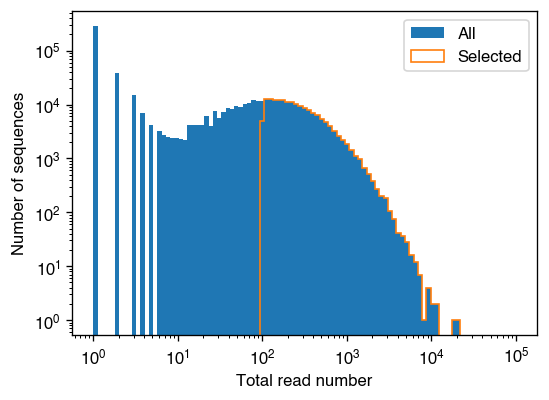

In [10]:
# Plot histogram with number of reads
pyplot.figure(figsize=(5, 3.5))
pyplot.hist(
    data_full['total'],
    bins=numpy.logspace(0, 5, 100),
    log=True,
    label='All')
pyplot.hist(
    data['total'],
    bins=numpy.logspace(0, 5, 100),
    log=True,
    label='Selected',
    histtype='step')
pyplot.xscale('log')
pyplot.xlabel('Total read number')
pyplot.ylabel('Number of sequences')
pyplot.legend()

## Test predictions with Optimus 5-Prime - 50nt

In [11]:
# Load training data for rescaling
data_optimus_50nt = pandas.read_csv(
    '../polysome_profiling_sample2019/GSM3130435_egfp_unmod_1.csv.gz',
    usecols=['utr', 'rl', 'total_reads'],
)
data_optimus_50nt = data_optimus_50nt.sort_values('total_reads', ascending=False)
data_optimus_50nt = data_optimus_50nt.iloc[:260000]
data_optimus_50nt

,utr,total_reads,rl
0,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCG...,12126.0,3.039939
1,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTA...,10368.0,3.895109
2,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGAC...,9963.0,3.334524
3,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGT...,9934.0,3.575082
4,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTC...,9511.0,4.593712
...,...,...,...
260077,CCACTGCGGAAAAGGCTCAGCTTCCGGTCATATAGACACGCATGTC...,373.0,7.579744
260059,CCGGAACCGGTTTTTAGAGTAATACTTTCCATCATAAGACTGGCGG...,373.0,5.713483
260100,GCTAGCAAGCCATTTGCAAATCGGTTTGAGACCATCAGTCCAAGGC...,373.0,7.841596
260060,GCGCGCGACGGCAGACAGGACGTTGTCGAAGGGGCACATTCAGGAC...,373.0,7.822183


In [12]:
# Load optimus 5-prime-50nt model
model = tensorflow.keras.models.load_model('../models_sample2019/main_MRL_model.hdf5')
model.summary()

# Set output scaler from the model's training data
scaler = preprocessing.StandardScaler()
scaler.fit(data_optimus_50nt['rl'].values.reshape(-1,1))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 50, 120)           3960      
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 120)           115320    
                                                                 
 dropout_1 (Dropout)         (None, 50, 120)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 120)           115320    
                                                                 
 dropout_2 (Dropout)         (None, 50, 120)           0         
                                                                 
 flatten_1 (Flatten)         (None, 6000)              0         
                                                                 
 dense_1 (Dense)             (None, 40)                2

StandardScaler()

In [13]:
# Make predictions
data['rl_pred_50nt'] = scaler.inverse_transform(
    model.predict(
        one_hot_encode(data['UTR'], max_seq_len=50, mask_val=0, padding='right')
    ).reshape(-1, 1)
)

data

C:\Users\casti\AppData\Local\Temp\ipykernel_8316\2448463364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rl_pred_50nt'] = scaler.inverse_transform(


,UTR,total,rl,error,rl_pred_50nt
0,ACATCGTAGAGAGTCGTACTTACCG,20252.0,5.584273,0.140398,7.752742
1,AGAAGGTCGCGGCGTTTAGAATTCA,18955.0,6.683197,0.095390,7.721424
2,AGAGATGAGCATTAAAATGGAACAA,12267.0,6.175643,0.139664,7.689819
3,AGAGGATTTGAGGTTTTCGCATATT,11987.0,6.785426,0.158523,8.079588
4,TCTACCGACGGTTAGTATTTATGCC,10255.0,6.548138,0.009790,7.409330
...,...,...,...,...,...
168274,GCGGGGTACTTCTTCGGATTTAGGG,100.0,7.050512,0.078479,7.740694
168275,GACTGTAGAATCAGATAGCTTGTGT,100.0,5.052829,0.618704,7.273389
168276,TATACGGTCTTGCTATAAGACGGTT,100.0,7.261647,0.504847,7.954338
168277,TGTACCCCGGTATATTAATCAATCC,100.0,5.956888,1.443553,5.666131


C:\Users\casti\AppData\Local\Temp\ipykernel_8316\4124430324.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['uATG'] = data_to_plot['UTR'].str.contains('ATG')
C:\Users\casti\AppData\Local\Temp\ipykernel_8316\4124430324.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot.loc[data_to_plot['uATG'], 'uATG string'] = 'With uAUG'


No uAUG      1254
With uAUG     746
Name: uATG string, dtype: int64


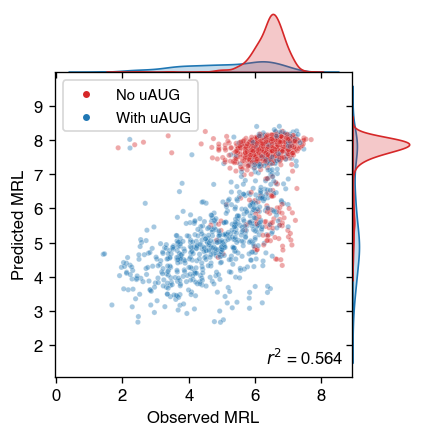

In [14]:
# Scatter plot of MRL vs prediction
data_to_plot = data[:2000]
# Assign whether uAUGs are present in the sequence
data_to_plot['uATG'] = data_to_plot['UTR'].str.contains('ATG')
data_to_plot.loc[data_to_plot['uATG'], 'uATG string'] = 'With uAUG'
data_to_plot.loc[~data_to_plot['uATG'], 'uATG string'] = 'No uAUG'
# Randomize order
data_to_plot = data_to_plot.sample(frac=1)

print(data_to_plot['uATG string'].value_counts())

uaug_colors = {True: 'tab:blue', False: 'tab:red'}

g = seaborn.JointGrid(
    data=data_to_plot,
    x="rl",
    y="rl_pred_50nt",
    hue="uATG string",
    palette={'With uAUG': 'tab:blue', 'No uAUG': 'tab:red'},
    height=3.75,
    space=.0,
)
g.plot_joint(seaborn.scatterplot, s=10, alpha=.4, rasterized=True)
g.plot_marginals(seaborn.kdeplot, fill=True,)

g.ax_joint.set_xlabel('Observed MRL')
g.ax_joint.set_ylabel('Predicted MRL')
leg = g.ax_joint.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_sizes([10])
for text in leg.texts:
    text.set_fontsize(9)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(data_to_plot['rl'], data_to_plot['rl_pred_50nt'])
# g.ax_joint.axline((3, 3*slope + intercept), slope=slope, color='k', linewidth=1, alpha=0.5)
xlim = g.ax_joint.get_xlim()
ylim = g.ax_joint.get_ylim()
xpos = xlim[0] + 0.97*(xlim[1] - xlim[0])
ypos = ylim[0] + 0.04*(ylim[1] - ylim[0])
g.ax_joint.text(xpos, ypos, f'$r^2$ = {r_value**2:.3f}', ha='right')

g.fig.savefig('N25_mrl_vs_optimus_50nt.svg', dpi=200, bbox_inches='tight')
g.fig.savefig('N25_mrl_vs_optimus_50nt.png', dpi=200, bbox_inches='tight')

## Test predictions with Optimus 5-Prime - 100nt

In [15]:
# Load training data for rescaling
data_optimus_varnt = pandas.read_csv(
    '../polysome_profiling_sample2019/GSM4084997_varying_length_25to100.csv.gz',
    usecols=['utr', 'set', 'rl', 'len', 'total_reads'],
)
data_optimus_varnt = data_optimus_varnt[data_optimus_varnt['set']=='random']
data_optimus_varnt = data_optimus_varnt[data_optimus_varnt['total_reads'] >= 10]

# Take the top 100 UTRs with most sequencing reads at each length from 25 to 100nt as the test set.
data_optimus_varnt_test = pandas.DataFrame(columns=data_optimus_varnt.columns)
for i in range(25,101):
    tmp = data_optimus_varnt[data_optimus_varnt['len']==i]
    tmp = tmp.sort_values('total_reads', ascending=False)
    tmp.reset_index(inplace=True, drop=True)
    data_optimus_varnt_test = pandas.concat([data_optimus_varnt_test, tmp.iloc[:100]], axis=0)

# Everything else is the original training set
data_optimus_varnt = pandas.concat(
    [data_optimus_varnt, data_optimus_varnt_test, data_optimus_varnt_test]
).drop_duplicates(keep=False)

data_optimus_varnt

,utr,set,total_reads,rl,len
0,GTTTTTGGCGCTCCCCTCTTAGCTT,random,1811,5.386932,25
1,CGCCCCGACTCCCGTTGGCGGGTCT,random,1699,5.080745,25
2,CTTACGGCCTCTCCAGCCCGCTTGT,random,1378,4.995427,25
3,TCAGCGGCCATAATGTCCTCCTCTG,random,1819,2.779368,25
4,GACCCTCCTATTATCAACCAAGATA,random,2401,5.552591,25
...,...,...,...,...,...
86992,TCATACTAGACTTTATTCTCTAAATATACACCTTCTACACTTAAAT...,random,16,6.518483,100
86993,ATTCCCCTCTGCAACTACGCACCCTATACACCTCTTCATATAACAG...,random,42,6.411701,100
86994,GCATCCTTGTCGCGTAAACCATCACTACTCTCCGCTGACTCCCCTA...,random,56,5.611533,100
86996,TTGAGCGCTGCCTTGACCCTCTAGTCTCACCGATTTCCGAACATAG...,random,26,3.177686,100


In [16]:
# Load optimus 5-prime - var length model
model = tensorflow.keras.models.load_model('../models_sample2019/Varying_length_25to100_model.hdf5')
model.summary()

# Set output scaler from the model's training data
scaler = preprocessing.StandardScaler()
scaler.fit(data_optimus_varnt['rl'].values.reshape(-1,1))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 100, 120)          3960      
                                                                 
 conv1d_11 (Conv1D)          (None, 100, 120)          115320    
                                                                 
 dropout_10 (Dropout)        (None, 100, 120)          0         
                                                                 
 conv1d_12 (Conv1D)          (None, 100, 120)          115320    
                                                                 
 dropout_11 (Dropout)        (None, 100, 120)          0         
                                                                 
 flatten_4 (Flatten)         (None, 12000)             0         
                                                                 
 dense_7 (Dense)             (None, 40)               

StandardScaler()

In [17]:
# Make predictions
data['rl_pred_varnt'] = scaler.inverse_transform(
    model.predict(
        one_hot_encode(data['UTR'], max_seq_len=100, mask_val=0, padding='right')
    ).reshape(-1, 1)
)

data

C:\Users\casti\AppData\Local\Temp\ipykernel_8316\3150108413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rl_pred_varnt'] = scaler.inverse_transform(


,UTR,total,rl,error,rl_pred_50nt,rl_pred_varnt
0,ACATCGTAGAGAGTCGTACTTACCG,20252.0,5.584273,0.140398,7.752742,6.066284
1,AGAAGGTCGCGGCGTTTAGAATTCA,18955.0,6.683197,0.095390,7.721424,5.950841
2,AGAGATGAGCATTAAAATGGAACAA,12267.0,6.175643,0.139664,7.689819,6.450357
3,AGAGGATTTGAGGTTTTCGCATATT,11987.0,6.785426,0.158523,8.079588,6.063350
4,TCTACCGACGGTTAGTATTTATGCC,10255.0,6.548138,0.009790,7.409330,5.853494
...,...,...,...,...,...,...
168274,GCGGGGTACTTCTTCGGATTTAGGG,100.0,7.050512,0.078479,7.740694,6.040350
168275,GACTGTAGAATCAGATAGCTTGTGT,100.0,5.052829,0.618704,7.273389,5.498333
168276,TATACGGTCTTGCTATAAGACGGTT,100.0,7.261647,0.504847,7.954338,6.000715
168277,TGTACCCCGGTATATTAATCAATCC,100.0,5.956888,1.443553,5.666131,4.554953


C:\Users\casti\AppData\Local\Temp\ipykernel_8316\2517231873.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['uATG'] = data_to_plot['UTR'].str.contains('ATG')
C:\Users\casti\AppData\Local\Temp\ipykernel_8316\2517231873.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot.loc[data_to_plot['uATG'], 'uATG string'] = 'With uAUG'


No uAUG      1254
With uAUG     746
Name: uATG string, dtype: int64


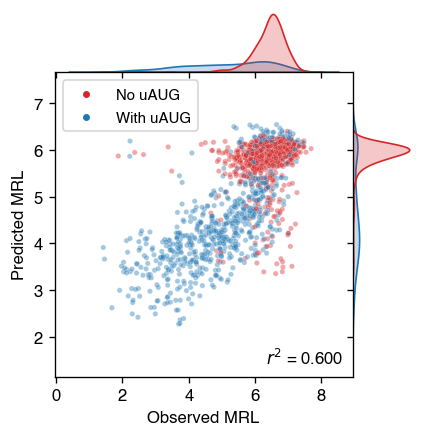

In [18]:
# Scatter plot of MRL vs prediction
data_to_plot = data[:2000]
# Assign whether uAUGs are present in the sequence
data_to_plot['uATG'] = data_to_plot['UTR'].str.contains('ATG')
data_to_plot.loc[data_to_plot['uATG'], 'uATG string'] = 'With uAUG'
data_to_plot.loc[~data_to_plot['uATG'], 'uATG string'] = 'No uAUG'
# Randomize order
data_to_plot = data_to_plot.sample(frac=1)

print(data_to_plot['uATG string'].value_counts())

uaug_colors = {True: 'tab:blue', False: 'tab:red'}

g = seaborn.JointGrid(
    data=data_to_plot,
    x="rl",
    y="rl_pred_varnt",
    hue="uATG string",
    palette={'With uAUG': 'tab:blue', 'No uAUG': 'tab:red'},
    height=3.75,
    space=.0,
)
g.plot_joint(seaborn.scatterplot, s=10, alpha=.4, rasterized=True)
g.plot_marginals(seaborn.kdeplot, fill=True,)

g.ax_joint.set_xlabel('Observed MRL')
g.ax_joint.set_ylabel('Predicted MRL')
leg = g.ax_joint.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_sizes([10])
for text in leg.texts:
    text.set_fontsize(9)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(data_to_plot['rl'], data_to_plot['rl_pred_varnt'])
# g.ax_joint.axline((3, 3*slope + intercept), slope=slope, color='k', linewidth=1, alpha=0.5)
xlim = g.ax_joint.get_xlim()
ylim = g.ax_joint.get_ylim()
xpos = xlim[0] + 0.97*(xlim[1] - xlim[0])
ypos = ylim[0] + 0.04*(ylim[1] - ylim[0])
g.ax_joint.text(xpos, ypos, f'$r^2$ = {r_value**2:.3f}', ha='right')

g.fig.savefig('N25_mrl_vs_optimus_varnt.svg', dpi=200, bbox_inches='tight')
g.fig.savefig('N25_mrl_vs_optimus_varnt.png', dpi=200, bbox_inches='tight')

# N50 library

In [19]:
data_full = pandas.read_csv('../polysome_profiling_data/GSE232927_processed_random_end_hek293t_N50_r1.csv.gz')

# Preserve only sequences with largest number of reads
data_full.sort_values('total', inplace=True, ascending=False)
data_full.reset_index(inplace=True, drop=True)
data = data_full[data_full['total'] >= 100]

data

,UTR,0,1,2,3,4,5,6,7,8,9,10,11,12,total,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r_total,rl
0,GAGCAGTCTTAATAAACGTTTTTTTGGAAGATAGTGTAATGTGAAG...,1032.0,2676.0,2724.0,1715.0,832.0,508.0,391.0,279.0,340.0,273.0,306.0,248.0,161.0,11485.0,0.134091,0.182029,0.170693,0.118088,0.071384,0.048497,0.032255,0.028323,0.031638,0.043711,0.050040,0.047066,0.042185,0.002362,4.040015
1,TATTAGTCATACGGACTCATGCTTCCTACAATTGTGTTCGAAGTAC...,489.0,841.0,1356.0,1812.0,953.0,732.0,529.0,297.0,425.0,256.0,292.0,277.0,176.0,8435.0,0.081157,0.073072,0.108534,0.159367,0.104441,0.089261,0.055741,0.038511,0.050515,0.052356,0.060993,0.067148,0.058904,0.001849,5.262928
2,AGATCAACTTGGTCTTCGACAATGTATGACGTTTGGAGTGTCTCGG...,658.0,1429.0,2298.0,1343.0,469.0,365.0,209.0,178.0,217.0,180.0,217.0,199.0,155.0,7917.0,0.123469,0.140378,0.207956,0.133546,0.058112,0.050322,0.024899,0.026095,0.029161,0.041621,0.051247,0.054541,0.058652,0.001635,4.286154
3,GAGAGGTATTTTCTCGAACATTTGACGTTCTTCATGTTTTGTGACT...,278.0,346.0,434.0,1277.0,1127.0,902.0,794.0,384.0,415.0,295.0,331.0,284.0,180.0,7047.0,0.051374,0.033474,0.038679,0.125057,0.137524,0.122472,0.093157,0.055442,0.054924,0.067178,0.076985,0.076657,0.067079,0.001661,6.152285
4,GGAAGGTATGTAATTATTCCATTCTGGTTCGTAACTATGATCACCC...,972.0,1064.0,1281.0,1419.0,538.0,325.0,189.0,160.0,243.0,132.0,148.0,118.0,100.0,6689.0,0.209717,0.120183,0.133293,0.162246,0.076650,0.051521,0.025890,0.026971,0.037548,0.035095,0.040189,0.037187,0.043510,0.001422,3.805979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148684,ACTGGTTACAGATCCTCACACTAAGTGTACCGTGGGGATCGGTTAC...,1.0,4.0,3.0,16.0,14.0,14.0,11.0,10.0,2.0,8.0,11.0,1.0,5.0,100.0,0.011901,0.024922,0.017219,0.100909,0.110021,0.122419,0.083115,0.092982,0.017046,0.117323,0.164763,0.017383,0.119998,0.000026,7.142521
148685,CCTACATGCGGCGTCGAGAAAGCCATTGTTTTCAGAAATTGTAGGG...,0.0,3.0,4.0,11.0,12.0,13.0,9.0,6.0,11.0,4.0,10.0,7.0,10.0,100.0,0.000000,0.016890,0.020745,0.062688,0.085214,0.102717,0.061448,0.050412,0.084718,0.053007,0.135347,0.109952,0.216862,0.000029,8.321686
148686,CACTTCCTGAAGCCGACCTTAGTTACAGACGGCTAGGTTCCTATTC...,3.0,6.0,8.0,9.0,14.0,8.0,9.0,11.0,11.0,8.0,6.0,3.0,4.0,100.0,0.036614,0.038337,0.047088,0.058210,0.112828,0.071739,0.069738,0.104890,0.096148,0.120317,0.092164,0.053480,0.098448,0.000025,6.876430
148687,CAAGCTCGTTAATTTAGTTAATATATCTAAACCATAAGCATTTCAG...,3.0,7.0,11.0,2.0,5.0,12.0,15.0,12.0,13.0,3.0,8.0,8.0,1.0,100.0,0.037118,0.045341,0.065636,0.013113,0.040850,0.109087,0.117829,0.115998,0.115191,0.045739,0.124575,0.144573,0.024950,0.000025,6.973769


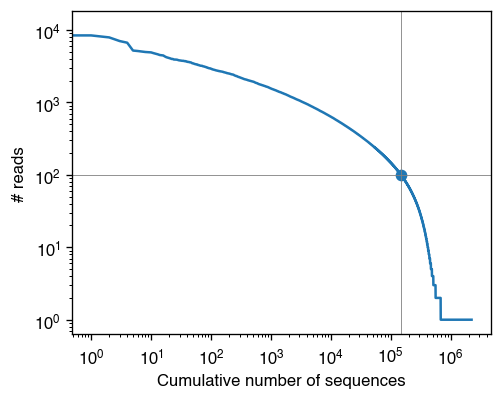

In [20]:
fig, ax = pyplot.subplots(1, 1, figsize=(4.5, 3.5))
ax.plot(data_full['total'])
ax.axhline(100, color='gray', linewidth=0.5)
ax.axvline(len(data), color='gray', linewidth=0.5)
ax.scatter(len(data), 100)
ax.set_xscale('log')
ax.set_xlabel('Cumulative number of sequences')
ax.set_yscale('log')
ax.set_ylabel(f'# reads')
fig.savefig('N50_reads_nseqs.png', dpi=200, bbox_inches='tight')
fig.savefig('N50_reads_nseqs.svg', dpi=200, bbox_inches='tight')

2,238,030 total sequences, 148,689 retained.


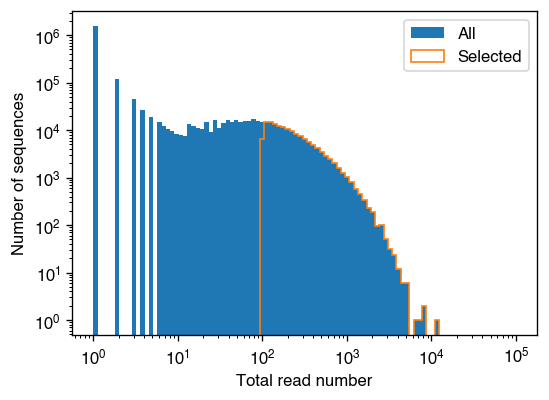

In [21]:
# Plot histogram with number of reads
pyplot.figure(figsize=(5, 3.5))
pyplot.hist(
    data_full['total'],
    bins=numpy.logspace(0, 5, 100),
    log=True,
    label='All')
pyplot.hist(
    data['total'],
    bins=numpy.logspace(0, 5, 100),
    log=True,
    label='Selected',
    histtype='step')
pyplot.xscale('log')
pyplot.xlabel('Total read number')
pyplot.ylabel('Number of sequences')
pyplot.legend()

print("{:,} total sequences, {:,} retained.".format(len(data_full), len(data)))

## Test predictions with Optimus 5-Prime - 50nt

In [22]:
# Load training data for rescaling
data_optimus_50nt = pandas.read_csv(
    '../polysome_profiling_sample2019/GSM3130435_egfp_unmod_1.csv.gz',
    usecols=['utr', 'rl', 'total_reads'],
)
data_optimus_50nt = data_optimus_50nt.sort_values('total_reads', ascending=False)
data_optimus_50nt = data_optimus_50nt.iloc[:260000]
data_optimus_50nt

,utr,total_reads,rl
0,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCG...,12126.0,3.039939
1,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTA...,10368.0,3.895109
2,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGAC...,9963.0,3.334524
3,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGT...,9934.0,3.575082
4,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTC...,9511.0,4.593712
...,...,...,...
260077,CCACTGCGGAAAAGGCTCAGCTTCCGGTCATATAGACACGCATGTC...,373.0,7.579744
260059,CCGGAACCGGTTTTTAGAGTAATACTTTCCATCATAAGACTGGCGG...,373.0,5.713483
260100,GCTAGCAAGCCATTTGCAAATCGGTTTGAGACCATCAGTCCAAGGC...,373.0,7.841596
260060,GCGCGCGACGGCAGACAGGACGTTGTCGAAGGGGCACATTCAGGAC...,373.0,7.822183


In [23]:
# Load optimus 5-prime-50nt model
model = tensorflow.keras.models.load_model('../models_sample2019/main_MRL_model.hdf5')
model.summary()

# Set output scaler from the model's training data
scaler = preprocessing.StandardScaler()
scaler.fit(data_optimus_50nt['rl'].values.reshape(-1,1))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 50, 120)           3960      
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 120)           115320    
                                                                 
 dropout_1 (Dropout)         (None, 50, 120)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 120)           115320    
                                                                 
 dropout_2 (Dropout)         (None, 50, 120)           0         
                                                                 
 flatten_1 (Flatten)         (None, 6000)              0         
                                                                 
 dense_1 (Dense)             (None, 40)               

StandardScaler()

In [24]:
# Make predictions
data['rl_pred_50nt'] = scaler.inverse_transform(
    model.predict(
        one_hot_encode(data['UTR'], max_seq_len=50, mask_val=0, padding='right')
    ).reshape(-1, 1)
)

data

C:\Users\casti\AppData\Local\Temp\ipykernel_8316\2448463364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rl_pred_50nt'] = scaler.inverse_transform(


,UTR,0,1,2,3,4,5,6,7,8,9,10,11,12,total,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r_total,rl,rl_pred_50nt
0,GAGCAGTCTTAATAAACGTTTTTTTGGAAGATAGTGTAATGTGAAG...,1032.0,2676.0,2724.0,1715.0,832.0,508.0,391.0,279.0,340.0,273.0,306.0,248.0,161.0,11485.0,0.134091,0.182029,0.170693,0.118088,0.071384,0.048497,0.032255,0.028323,0.031638,0.043711,0.050040,0.047066,0.042185,0.002362,4.040015,5.400489
1,TATTAGTCATACGGACTCATGCTTCCTACAATTGTGTTCGAAGTAC...,489.0,841.0,1356.0,1812.0,953.0,732.0,529.0,297.0,425.0,256.0,292.0,277.0,176.0,8435.0,0.081157,0.073072,0.108534,0.159367,0.104441,0.089261,0.055741,0.038511,0.050515,0.052356,0.060993,0.067148,0.058904,0.001849,5.262928,6.014809
2,AGATCAACTTGGTCTTCGACAATGTATGACGTTTGGAGTGTCTCGG...,658.0,1429.0,2298.0,1343.0,469.0,365.0,209.0,178.0,217.0,180.0,217.0,199.0,155.0,7917.0,0.123469,0.140378,0.207956,0.133546,0.058112,0.050322,0.024899,0.026095,0.029161,0.041621,0.051247,0.054541,0.058652,0.001635,4.286154,4.285891
3,GAGAGGTATTTTCTCGAACATTTGACGTTCTTCATGTTTTGTGACT...,278.0,346.0,434.0,1277.0,1127.0,902.0,794.0,384.0,415.0,295.0,331.0,284.0,180.0,7047.0,0.051374,0.033474,0.038679,0.125057,0.137524,0.122472,0.093157,0.055442,0.054924,0.067178,0.076985,0.076657,0.067079,0.001661,6.152285,6.551623
4,GGAAGGTATGTAATTATTCCATTCTGGTTCGTAACTATGATCACCC...,972.0,1064.0,1281.0,1419.0,538.0,325.0,189.0,160.0,243.0,132.0,148.0,118.0,100.0,6689.0,0.209717,0.120183,0.133293,0.162246,0.076650,0.051521,0.025890,0.026971,0.037548,0.035095,0.040189,0.037187,0.043510,0.001422,3.805979,4.157619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148684,ACTGGTTACAGATCCTCACACTAAGTGTACCGTGGGGATCGGTTAC...,1.0,4.0,3.0,16.0,14.0,14.0,11.0,10.0,2.0,8.0,11.0,1.0,5.0,100.0,0.011901,0.024922,0.017219,0.100909,0.110021,0.122419,0.083115,0.092982,0.017046,0.117323,0.164763,0.017383,0.119998,0.000026,7.142521,7.774950
148685,CCTACATGCGGCGTCGAGAAAGCCATTGTTTTCAGAAATTGTAGGG...,0.0,3.0,4.0,11.0,12.0,13.0,9.0,6.0,11.0,4.0,10.0,7.0,10.0,100.0,0.000000,0.016890,0.020745,0.062688,0.085214,0.102717,0.061448,0.050412,0.084718,0.053007,0.135347,0.109952,0.216862,0.000029,8.321686,5.867302
148686,CACTTCCTGAAGCCGACCTTAGTTACAGACGGCTAGGTTCCTATTC...,3.0,6.0,8.0,9.0,14.0,8.0,9.0,11.0,11.0,8.0,6.0,3.0,4.0,100.0,0.036614,0.038337,0.047088,0.058210,0.112828,0.071739,0.069738,0.104890,0.096148,0.120317,0.092164,0.053480,0.098448,0.000025,6.876430,7.437473
148687,CAAGCTCGTTAATTTAGTTAATATATCTAAACCATAAGCATTTCAG...,3.0,7.0,11.0,2.0,5.0,12.0,15.0,12.0,13.0,3.0,8.0,8.0,1.0,100.0,0.037118,0.045341,0.065636,0.013113,0.040850,0.109087,0.117829,0.115998,0.115191,0.045739,0.124575,0.144573,0.024950,0.000025,6.973769,8.172456


C:\Users\casti\AppData\Local\Temp\ipykernel_8316\240535413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['uATG'] = data_to_plot['UTR'].str.contains('ATG')
C:\Users\casti\AppData\Local\Temp\ipykernel_8316\240535413.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot.loc[data_to_plot['uATG'], 'uATG string'] = 'With uAUG'


With uAUG    1412
No uAUG       588
Name: uATG string, dtype: int64


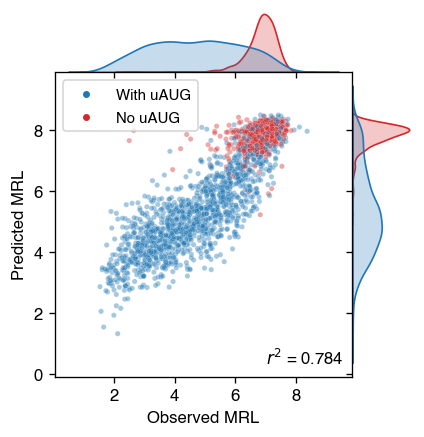

In [25]:
# Scatter plot of MRL vs prediction
data_to_plot = data[:2000]
# Assign whether uAUGs are present in the sequence
data_to_plot['uATG'] = data_to_plot['UTR'].str.contains('ATG')
data_to_plot.loc[data_to_plot['uATG'], 'uATG string'] = 'With uAUG'
data_to_plot.loc[~data_to_plot['uATG'], 'uATG string'] = 'No uAUG'
# Randomize order
data_to_plot = data_to_plot.sample(frac=1)

print(data_to_plot['uATG string'].value_counts())

uaug_colors = {True: 'tab:blue', False: 'tab:red'}

g = seaborn.JointGrid(
    data=data_to_plot,
    x="rl",
    y="rl_pred_50nt",
    hue="uATG string",
    palette={'With uAUG': 'tab:blue', 'No uAUG': 'tab:red'},
    height=3.75,
    space=.0,
)
g.plot_joint(seaborn.scatterplot, s=10, alpha=.4, rasterized=True)
g.plot_marginals(seaborn.kdeplot, fill=True,)

g.ax_joint.set_xlabel('Observed MRL')
g.ax_joint.set_ylabel('Predicted MRL')
leg = g.ax_joint.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_sizes([10])
for text in leg.texts:
    text.set_fontsize(9)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(data_to_plot['rl'], data_to_plot['rl_pred_50nt'])
# g.ax_joint.axline((3, 3*slope + intercept), slope=slope, color='k', linewidth=1, alpha=0.5)
xlim = g.ax_joint.get_xlim()
ylim = g.ax_joint.get_ylim()
xpos = xlim[0] + 0.97*(xlim[1] - xlim[0])
ypos = ylim[0] + 0.04*(ylim[1] - ylim[0])
g.ax_joint.text(xpos, ypos, f'$r^2$ = {r_value**2:.3f}', ha='right')

g.fig.savefig('N50_mrl_vs_optimus_50nt.svg', dpi=200, bbox_inches='tight')
g.fig.savefig('N50_mrl_vs_optimus_50nt.png', dpi=200, bbox_inches='tight')

## Test predictions with Optimus 5-Prime - 100nt

In [26]:
# Load training data for rescaling
data_optimus_varnt = pandas.read_csv(
    '../polysome_profiling_sample2019/GSM4084997_varying_length_25to100.csv.gz',
    usecols=['utr', 'set', 'rl', 'len', 'total_reads'],
)
data_optimus_varnt = data_optimus_varnt[data_optimus_varnt['set']=='random']
data_optimus_varnt = data_optimus_varnt[data_optimus_varnt['total_reads'] >= 10]

# Take the top 100 UTRs with most sequencing reads at each length from 25 to 100nt as the test set.
data_optimus_varnt_test = pandas.DataFrame(columns=data_optimus_varnt.columns)
for i in range(25,101):
    tmp = data_optimus_varnt[data_optimus_varnt['len']==i]
    tmp = tmp.sort_values('total_reads', ascending=False)
    tmp.reset_index(inplace=True, drop=True)
    data_optimus_varnt_test = pandas.concat([data_optimus_varnt_test, tmp.iloc[:100]], axis=0)

# Everything else is the original training set
data_optimus_varnt = pandas.concat(
    [data_optimus_varnt, data_optimus_varnt_test, data_optimus_varnt_test]
).drop_duplicates(keep=False)

data_optimus_varnt

,utr,set,total_reads,rl,len
0,GTTTTTGGCGCTCCCCTCTTAGCTT,random,1811,5.386932,25
1,CGCCCCGACTCCCGTTGGCGGGTCT,random,1699,5.080745,25
2,CTTACGGCCTCTCCAGCCCGCTTGT,random,1378,4.995427,25
3,TCAGCGGCCATAATGTCCTCCTCTG,random,1819,2.779368,25
4,GACCCTCCTATTATCAACCAAGATA,random,2401,5.552591,25
...,...,...,...,...,...
86992,TCATACTAGACTTTATTCTCTAAATATACACCTTCTACACTTAAAT...,random,16,6.518483,100
86993,ATTCCCCTCTGCAACTACGCACCCTATACACCTCTTCATATAACAG...,random,42,6.411701,100
86994,GCATCCTTGTCGCGTAAACCATCACTACTCTCCGCTGACTCCCCTA...,random,56,5.611533,100
86996,TTGAGCGCTGCCTTGACCCTCTAGTCTCACCGATTTCCGAACATAG...,random,26,3.177686,100


In [27]:
# Load optimus 5-prime - var length model
model = tensorflow.keras.models.load_model('../models_sample2019/Varying_length_25to100_model.hdf5')
model.summary()

# Set output scaler from the model's training data
scaler = preprocessing.StandardScaler()
scaler.fit(data_optimus_varnt['rl'].values.reshape(-1,1))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 100, 120)          3960      
                                                                 
 conv1d_11 (Conv1D)          (None, 100, 120)          115320    
                                                                 
 dropout_10 (Dropout)        (None, 100, 120)          0         
                                                                 
 conv1d_12 (Conv1D)          (None, 100, 120)          115320    
                                                                 
 dropout_11 (Dropout)        (None, 100, 120)          0         
                                                                 
 flatten_4 (Flatten)         (None, 12000)             0         
                                                                 
 dense_7 (Dense)             (None, 40)               

StandardScaler()

In [28]:
# Make predictions
data['rl_pred_varnt'] = scaler.inverse_transform(
    model.predict(
        one_hot_encode(data['UTR'], max_seq_len=100, mask_val=0, padding='right')
    ).reshape(-1, 1)
)

data

C:\Users\casti\AppData\Local\Temp\ipykernel_8316\3150108413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rl_pred_varnt'] = scaler.inverse_transform(


,UTR,0,1,2,3,4,5,6,7,8,9,10,11,12,total,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r_total,rl,rl_pred_50nt,rl_pred_varnt
0,GAGCAGTCTTAATAAACGTTTTTTTGGAAGATAGTGTAATGTGAAG...,1032.0,2676.0,2724.0,1715.0,832.0,508.0,391.0,279.0,340.0,273.0,306.0,248.0,161.0,11485.0,0.134091,0.182029,0.170693,0.118088,0.071384,0.048497,0.032255,0.028323,0.031638,0.043711,0.050040,0.047066,0.042185,0.002362,4.040015,5.400489,5.053244
1,TATTAGTCATACGGACTCATGCTTCCTACAATTGTGTTCGAAGTAC...,489.0,841.0,1356.0,1812.0,953.0,732.0,529.0,297.0,425.0,256.0,292.0,277.0,176.0,8435.0,0.081157,0.073072,0.108534,0.159367,0.104441,0.089261,0.055741,0.038511,0.050515,0.052356,0.060993,0.067148,0.058904,0.001849,5.262928,6.014809,4.230191
2,AGATCAACTTGGTCTTCGACAATGTATGACGTTTGGAGTGTCTCGG...,658.0,1429.0,2298.0,1343.0,469.0,365.0,209.0,178.0,217.0,180.0,217.0,199.0,155.0,7917.0,0.123469,0.140378,0.207956,0.133546,0.058112,0.050322,0.024899,0.026095,0.029161,0.041621,0.051247,0.054541,0.058652,0.001635,4.286154,4.285891,3.182056
3,GAGAGGTATTTTCTCGAACATTTGACGTTCTTCATGTTTTGTGACT...,278.0,346.0,434.0,1277.0,1127.0,902.0,794.0,384.0,415.0,295.0,331.0,284.0,180.0,7047.0,0.051374,0.033474,0.038679,0.125057,0.137524,0.122472,0.093157,0.055442,0.054924,0.067178,0.076985,0.076657,0.067079,0.001661,6.152285,6.551623,5.151025
4,GGAAGGTATGTAATTATTCCATTCTGGTTCGTAACTATGATCACCC...,972.0,1064.0,1281.0,1419.0,538.0,325.0,189.0,160.0,243.0,132.0,148.0,118.0,100.0,6689.0,0.209717,0.120183,0.133293,0.162246,0.076650,0.051521,0.025890,0.026971,0.037548,0.035095,0.040189,0.037187,0.043510,0.001422,3.805979,4.157619,3.955035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148684,ACTGGTTACAGATCCTCACACTAAGTGTACCGTGGGGATCGGTTAC...,1.0,4.0,3.0,16.0,14.0,14.0,11.0,10.0,2.0,8.0,11.0,1.0,5.0,100.0,0.011901,0.024922,0.017219,0.100909,0.110021,0.122419,0.083115,0.092982,0.017046,0.117323,0.164763,0.017383,0.119998,0.000026,7.142521,7.774950,6.543519
148685,CCTACATGCGGCGTCGAGAAAGCCATTGTTTTCAGAAATTGTAGGG...,0.0,3.0,4.0,11.0,12.0,13.0,9.0,6.0,11.0,4.0,10.0,7.0,10.0,100.0,0.000000,0.016890,0.020745,0.062688,0.085214,0.102717,0.061448,0.050412,0.084718,0.053007,0.135347,0.109952,0.216862,0.000029,8.321686,5.867302,5.706159
148686,CACTTCCTGAAGCCGACCTTAGTTACAGACGGCTAGGTTCCTATTC...,3.0,6.0,8.0,9.0,14.0,8.0,9.0,11.0,11.0,8.0,6.0,3.0,4.0,100.0,0.036614,0.038337,0.047088,0.058210,0.112828,0.071739,0.069738,0.104890,0.096148,0.120317,0.092164,0.053480,0.098448,0.000025,6.876430,7.437473,6.063372
148687,CAAGCTCGTTAATTTAGTTAATATATCTAAACCATAAGCATTTCAG...,3.0,7.0,11.0,2.0,5.0,12.0,15.0,12.0,13.0,3.0,8.0,8.0,1.0,100.0,0.037118,0.045341,0.065636,0.013113,0.040850,0.109087,0.117829,0.115998,0.115191,0.045739,0.124575,0.144573,0.024950,0.000025,6.973769,8.172456,6.605414


C:\Users\casti\AppData\Local\Temp\ipykernel_8316\890520469.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['uATG'] = data_to_plot['UTR'].str.contains('ATG')
C:\Users\casti\AppData\Local\Temp\ipykernel_8316\890520469.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot.loc[data_to_plot['uATG'], 'uATG string'] = 'With uAUG'


With uAUG    1412
No uAUG       588
Name: uATG string, dtype: int64


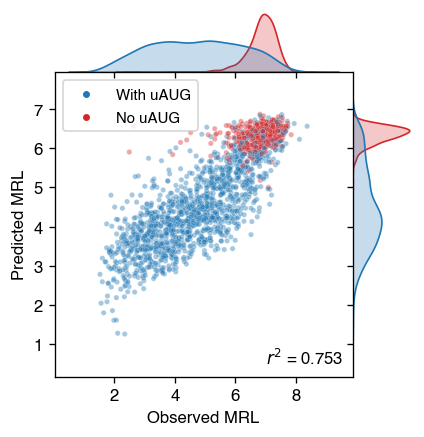

In [29]:
# Scatter plot of MRL vs prediction
data_to_plot = data[:2000]
# Assign whether uAUGs are present in the sequence
data_to_plot['uATG'] = data_to_plot['UTR'].str.contains('ATG')
data_to_plot.loc[data_to_plot['uATG'], 'uATG string'] = 'With uAUG'
data_to_plot.loc[~data_to_plot['uATG'], 'uATG string'] = 'No uAUG'
# Randomize order
data_to_plot = data_to_plot.sample(frac=1)

print(data_to_plot['uATG string'].value_counts())

uaug_colors = {True: 'tab:blue', False: 'tab:red'}

g = seaborn.JointGrid(
    data=data_to_plot,
    x="rl",
    y="rl_pred_varnt",
    hue="uATG string",
    palette={'With uAUG': 'tab:blue', 'No uAUG': 'tab:red'},
    height=3.75,
    space=.0,
)
g.plot_joint(seaborn.scatterplot, s=10, alpha=.4, rasterized=True)
g.plot_marginals(seaborn.kdeplot, fill=True,)

g.ax_joint.set_xlabel('Observed MRL')
g.ax_joint.set_ylabel('Predicted MRL')
leg = g.ax_joint.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_sizes([10])
for text in leg.texts:
    text.set_fontsize(9)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(data_to_plot['rl'], data_to_plot['rl_pred_varnt'])
# g.ax_joint.axline((3, 3*slope + intercept), slope=slope, color='k', linewidth=1, alpha=0.5)
xlim = g.ax_joint.get_xlim()
ylim = g.ax_joint.get_ylim()
xpos = xlim[0] + 0.97*(xlim[1] - xlim[0])
ypos = ylim[0] + 0.04*(ylim[1] - ylim[0])
g.ax_joint.text(xpos, ypos, f'$r^2$ = {r_value**2:.3f}', ha='right')

g.fig.savefig('N50_mrl_vs_optimus_varnt.svg', dpi=200, bbox_inches='tight')
g.fig.savefig('N50_mrl_vs_optimus_varnt.png', dpi=200, bbox_inches='tight')